In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest


In [126]:
# Load and preprocess data
train_df, test_df = load_data('./train data.csv', './test data.csv')

In [127]:
train_df.head()

,ID,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,1,Bobby JacksOn,27,Female,O-,Asthma,06/06/2022,Mark Hartman Jr.,Sons and Miller,Cigna,2625.980554,379,Elective,18/08/2022,Ibuprofen,Normal
1,2,LesLie TErRy,68,Female,O-,Cancer,19/11/2021,Angela Contreras,White-White,Cigna,1471.387317,113,Elective,20/11/2021,Ibuprofen,Inconclusive
2,3,DaNnY sMitH,21,Female,A+,Hypertension,05/03/2022,David Ruiz,Group Middleton,Medicare,5131.488104,154,Emergency,16/05/2022,Paracetamol,Normal
3,4,andrEw waTtS,91,Male,AB-,Diabetes,06/04/2020,Jenny Griffith,Morris-Arellano,Blue Cross,8972.793157,293,Urgent,26/04/2020,Ibuprofen,Abnormal
4,5,adrIENNE bEll,52,Female,A+,Diabetes,31/12/2022,Cynthia Scott,Williams-Davis,Blue Cross,2015.522684,265,Emergency,11/02/2023,Penicillin,Abnormal


# Load Dataset

In [128]:
# Load data
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

In [129]:
print((train_df.isnull().sum())/(50000)*100)

ID                    0.000
Name                  0.000
Age                   0.000
Gender                0.000
Blood Type            6.130
Medical Condition     0.000
Date of Admission     0.000
Doctor                1.608
Hospital              1.918
Insurance Provider    0.586
Billing Amount        1.448
Room Number           0.000
Admission Type        0.362
Discharge Date        0.000
Medication            0.000
Test Results          0.000
dtype: float64


# Data cleaning and preprocessing
1. Feature engineering
2. Impute null values
3. Drop irrelevant columns
4. Encode categorical data


In [130]:
# Preprocess dates
def preprocess_dates(df):
    df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], format='%d/%m/%Y')
    df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], format='%d/%m/%Y')
    df['No. Days admitted'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
    return df.drop(columns=['Date of Admission', 'Discharge Date'])

# Drop unnecessary columns
def drop_columns(df, columns):
    return df.drop(columns=columns, errors='ignore')

def fill_missing_numerical(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Billing Amount'].fillna(df['Billing Amount'].mean(), inplace=True)
    #fill b median 3shan data is skewed unlike el ba2y
    df['No. Days admitted'].fillna(df['No. Days admitted'].median(), inplace=True)
    df['Room Number'].fillna(df['Room Number'].mean(), inplace=True)
    return df

# Fil el categorical null values
def fill_missing_categorical(df):
    for col in ['Doctor', 'Hospital', 'Insurance Provider', 'Admission Type']:
        df[col].fillna(df[col].mode()[0], inplace=True)
    df['Medication'] = df['Medication'].fillna('unknown')
    df['Blood Type'] = df['Blood Type'].fillna('unknown')
    return df

# Encode categorical
def encode_categorical(df, fit_encoders=None):
    one_hot_cols = ["Gender", "Blood Type", "Medical Condition", "Admission Type"]
    label_cols = ["Insurance Provider", "Hospital", "Medication", "Doctor"]
    encoders = fit_encoders if fit_encoders else {col: LabelEncoder() for col in label_cols}
    for col in label_cols:
        df[col] = encoders[col].fit_transform(df[col].astype(str)) if not fit_encoders else encoders[col].transform(df[col].astype(str))
    df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True).astype(int)
    return df, encoders

def final_cleanup(df):
    df['Billing Amount'] = df['Billing Amount'].astype(int)
    return df


In [131]:
train_df = preprocess_dates(train_df)
train_df = fill_missing_numerical(train_df)
train_df = fill_missing_categorical(train_df)
train_df['Test Results'] = train_df['Test Results'].map({'Normal': 0, 'Inconclusive': 1, 'Abnormal': 2})
train_df = final_cleanup(train_df)
print("train_df after preprocessing: \n", train_df.head())


train_df after preprocessing: 
    ID           Name  Age  Gender Blood Type Medical Condition  \
0   1  Bobby JacksOn   27  Female         O-            Asthma   
1   2   LesLie TErRy   68  Female         O-            Cancer   
2   3    DaNnY sMitH   21  Female         A+      Hypertension   
3   4   andrEw waTtS   91    Male        AB-          Diabetes   
4   5  adrIENNE bEll   52  Female         A+          Diabetes   

             Doctor         Hospital Insurance Provider  Billing Amount  \
0  Mark Hartman Jr.  Sons and Miller              Cigna            2625   
1  Angela Contreras      White-White              Cigna            1471   
2        David Ruiz  Group Middleton           Medicare            5131   
3    Jenny Griffith  Morris-Arellano         Blue Cross            8972   
4     Cynthia Scott   Williams-Davis         Blue Cross            2015   

   Room Number Admission Type   Medication  Test Results  No. Days admitted  
0          379       Elective    Ibuprofen

<ipython-input-130-386ab45b97bc>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
<ipython-input-130-386ab45b97bc>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [132]:
df_categorical = train_df.select_dtypes(include=['object'])


In [133]:
from scipy.stats import chi2_contingency
for col in df_categorical.columns.to_list():
  contingency_table = pd.crosstab(train_df[col], train_df['Test Results'])
  print(f"-----{col}-----")
  print(contingency_table)
  chi2, p, dof, expected = chi2_contingency(contingency_table)

  print(f"Chi-square statistic = {chi2:.4f}")
  print(f"Degrees of freedom = {dof}")
  print(f"P-value = {p:.4f}")

  if p < 0.05:
    print(f"There is a statistically significant association between {col} and target categories.")
  else:
    print(f"There is NO statistically significant association between {col} and target categories.")

  print("\n\n")



-----Name-----
Test Results       0  1  2
Name                      
AARON DuncAn       0  0  1
AARON HicKS        0  1  0
AARON bAldWIN Jr.  0  0  1
AARON hAWkIns      0  0  1
AAROn HaRt         0  0  1
...               .. .. ..
zachaRy huLL       1  0  0
zachaRy oDOM       0  0  1
zachaRy raMirEZ    0  1  0
zacharY BauTista   0  1  0
zachary WALl       1  0  0

[49992 rows x 3 columns]
Chi-square statistic = 99984.9884
Degrees of freedom = 99982
P-value = 0.4967
There is NO statistically significant association between Name and target categories.



-----Gender-----
Test Results      0     1     2
Gender                         
Female        10930  8311  9273
Male           5754  8233  7499
Chi-square statistic = 822.1833
Degrees of freedom = 2
P-value = 0.0000
There is a statistically significant association between Gender and target categories.



-----Blood Type-----
Test Results     0     1     2
Blood Type                    
A+            3472  2552   849
A-             834  

In [134]:
#no correlation so drop it then encode
train_df = drop_columns(train_df, ["ID", "Name"])
train_df, encoders = encode_categorical(train_df)


In [135]:
train_df.head()

,Age,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Medication,Test Results,No. Days admitted,Gender_Male,...,Blood Type_O+,Blood Type_O-,Blood Type_unknown,Medical Condition_Asthma,Medical Condition_Cancer,Medical Condition_Diabetes,Medical Condition_Hypertension,Medical Condition_Obesity,Admission Type_Emergency,Admission Type_Urgent
0,27,135,48,2,2625,379,1,0,73,0,...,0,1,0,1,0,0,0,0,0,0
1,68,8,52,2,1471,113,1,1,1,0,...,0,1,0,0,1,0,0,0,0,0
2,21,37,16,3,5131,154,3,0,72,0,...,0,0,0,0,0,0,1,0,1,0
3,91,84,34,1,8972,293,1,2,20,1,...,0,0,0,0,0,1,0,0,0,1
4,52,29,53,1,2015,265,4,2,42,0,...,0,0,0,0,0,1,0,0,1,0


In [136]:
print((train_df.isnull().sum())/(50000)*100)

Age                               0.0
Doctor                            0.0
Hospital                          0.0
Insurance Provider                0.0
Billing Amount                    0.0
Room Number                       0.0
Medication                        0.0
Test Results                      0.0
No. Days admitted                 0.0
Gender_Male                       0.0
Blood Type_A-                     0.0
Blood Type_AB+                    0.0
Blood Type_AB-                    0.0
Blood Type_B+                     0.0
Blood Type_B-                     0.0
Blood Type_O+                     0.0
Blood Type_O-                     0.0
Blood Type_unknown                0.0
Medical Condition_Asthma          0.0
Medical Condition_Cancer          0.0
Medical Condition_Diabetes        0.0
Medical Condition_Hypertension    0.0
Medical Condition_Obesity         0.0
Admission Type_Emergency          0.0
Admission Type_Urgent             0.0
dtype: float64


<Axes: >

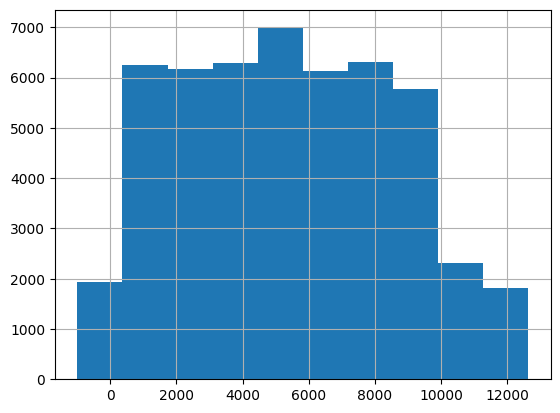

In [137]:
train_df['Billing Amount'].hist()  # If skewed, prefer median
# train_df['Age'].hist()
# train_df['Room Number'].hist()
# train_df['No. Days admitted'].hist()

In [138]:
# Test preprocessing
test_df = preprocess_dates(test_df)
test_df = drop_columns(test_df, ["ID", "Name"])
test_df = fill_missing_numerical(test_df)
test_df = fill_missing_categorical(test_df)
test_df, _ = encode_categorical(test_df, fit_encoders=encoders)
test_df = final_cleanup(test_df)
test_df.to_csv("cleaned_test_df.csv", index=False)
print("test_df after preprocessing: \n", test_df.head())


test_df after preprocessing: 
    Age  Doctor  Hospital  Insurance Provider  Billing Amount  Room Number  \
0   60      18        39                   2            1204          226   
1   85     182        35                   0            2177          254   
2   82     119        22                   2            8042          131   
3   57     158        19                   3            6060          280   
4   14      71        34                   1            6902          359   

   Medication  No. Days admitted  Gender_Male  Blood Type_A-  ...  \
0           2                 16            1              0  ...   
1           4                 11            1              1  ...   
2           4                 82            0              0  ...   
3           4                 43            1              0  ...   
4           2                 41            1              0  ...   

   Blood Type_O+  Blood Type_O-  Blood Type_unknown  Medical Condition_Asthma  \
0         

<ipython-input-130-386ab45b97bc>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
<ipython-input-130-386ab45b97bc>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr(), annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.close()

# Target variable distribution
sns.countplot(data=train_df, x='Test Results')
plt.title("Distribution of Test Results")
plt.savefig("target_distribution.png")
plt.close()

In [141]:
neg_bill=train_df[train_df['Billing Amount'] < 0]
print(neg_bill.count())


Age                               247
Doctor                            247
Hospital                          247
Insurance Provider                247
Billing Amount                    247
Room Number                       247
Medication                        247
Test Results                      247
No. Days admitted                 247
Gender_Male                       247
Blood Type_A-                     247
Blood Type_AB+                    247
Blood Type_AB-                    247
Blood Type_B+                     247
Blood Type_B-                     247
Blood Type_O+                     247
Blood Type_O-                     247
Blood Type_unknown                247
Medical Condition_Asthma          247
Medical Condition_Cancer          247
Medical Condition_Diabetes        247
Medical Condition_Hypertension    247
Medical Condition_Obesity         247
Admission Type_Emergency          247
Admission Type_Urgent             247
dtype: int64


In [142]:
unique_counts = train_df.nunique()
print(unique_counts)

Age                                 101
Doctor                              217
Hospital                             60
Insurance Provider                    5
Billing Amount                    12080
Room Number                         451
Medication                            5
Test Results                          3
No. Days admitted                   102
Gender_Male                           2
Blood Type_A-                         2
Blood Type_AB+                        2
Blood Type_AB-                        2
Blood Type_B+                         2
Blood Type_B-                         2
Blood Type_O+                         2
Blood Type_O-                         2
Blood Type_unknown                    2
Medical Condition_Asthma              2
Medical Condition_Cancer              2
Medical Condition_Diabetes            2
Medical Condition_Hypertension        2
Medical Condition_Obesity             2
Admission Type_Emergency              2
Admission Type_Urgent                 2


In [116]:
pip install deap scikit-learn numpy pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 6.1 MB/s eta 0:00:00


Selected Features: ['Age', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Medication', 'No. Days admitted', 'Gender_Male', 'Blood Type_AB-', 'Blood Type_B-', 'Blood Type_O+', 'Blood Type_O-', 'Medical Condition_Asthma', 'Medical Condition_Cancer', 'Medical Condition_Diabetes', 'Medical Condition_Hypertension', 'Medical Condition_Obesity', 'Admission Type_Emergency', 'Admission Type_Urgent']


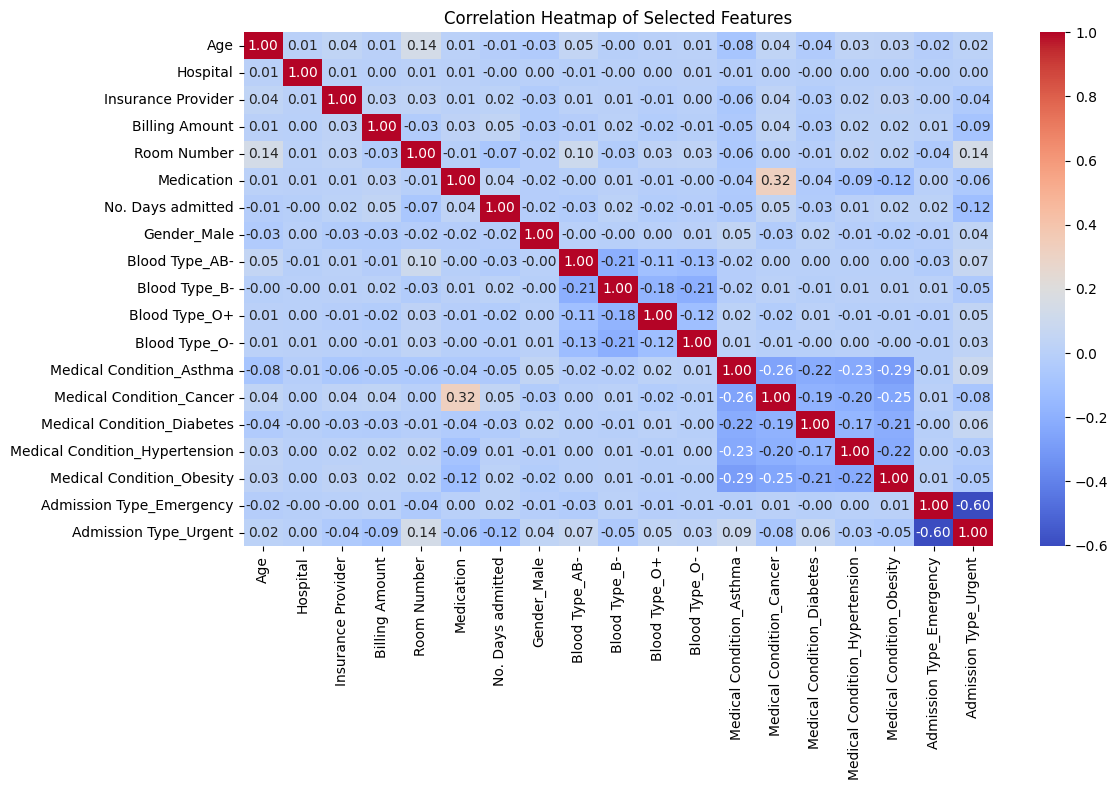

In [143]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Prepare data
X = train_df.drop('Test Results', axis=1).values
y = train_df['Test Results'].values
feature_names = train_df.drop('Test Results', axis=1).columns
num_features = X.shape[1]

# Parameters
population_size = 30
num_generations = 10
crossover_prob = 0.5
mutation_prob = 0.2

# Initialize population with random 0s and 1s
def initialize_population(size, num_features):
    return [np.random.randint(0, 2, num_features).tolist() for _ in range(size)]

# Evaluate individual (cross-validated accuracy)
def evaluate(individual):
    indices = [i for i, bit in enumerate(individual) if bit == 1]
    if not indices:
        return 0.0
    X_selected = X[:, indices]
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    return cross_val_score(clf, X_selected, y, cv=3).mean()

# Selection: tournament of 2
def select(population, scores):
    idx1, idx2 = random.sample(range(len(population)), 2)
    return population[idx1] if scores[idx1] > scores[idx2] else population[idx2]

# Crossover: single point
def crossover(p1, p2):
    if random.random() < crossover_prob:
        point = random.randint(1, num_features - 1)
        return p1[:point] + p2[point:], p2[:point] + p1[point:]
    return p1[:], p2[:]

# Mutation: flip bits
def mutate(individual):
    return [bit if random.random() > mutation_prob else 1 - bit for bit in individual]

# Genetic Algorithm
population = initialize_population(population_size, num_features)

for gen in range(num_generations):
    scores = [evaluate(ind) for ind in population]
    new_population = []

    while len(new_population) < population_size:
        parent1 = select(population, scores)
        parent2 = select(population, scores)
        child1, child2 = crossover(parent1, parent2)
        new_population += [mutate(child1), mutate(child2)]

    population = new_population[:population_size]

# Get best individual
scores = [evaluate(ind) for ind in population]
best_individual = population[np.argmax(scores)]
selected_indices = [i for i, bit in enumerate(best_individual) if bit == 1]
selected_features = feature_names[selected_indices].tolist()

print("Selected Features:", selected_features)

# Filter dataset
train_df = train_df[selected_features + ['Test Results']]
test_df = test_df[selected_features]

train_df.to_csv("selected_features_dataset.csv", index=False)
test_df.to_csv("test_selected_features_dataset.csv", index=False)

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.drop('Test Results', axis=1).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Selected Features")
plt.tight_layout()
plt.show()


In [147]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
# from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as colormap
import matplotlib.pyplot as plt # Import matplotlib.pyplot for plotting

# Split features and target
X = train_df.drop('Test Results', axis=1)
y = train_df['Test Results']

# Split Train into Train + Validation
# 80% train, 20% validation from labeled train.csv
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_df)

# Classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,), max_iter=500),
    # "SVM (Linear)": SVC(kernel='linear'),
    # "SVM (RBF Kernel)": SVC(kernel='rbf'),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boost": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Training and validation

best_model = None
best_score = 0
best_model_name = ""

for name, model in models.items():
    if "SVM" in name or "MLP" in name or "Logistic" in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    print(f"=== {name} ===")
    print("Validation Accuracy:", round(acc * 100, 2), "%")
    print(classification_report(y_val, y_pred, digits=3))

    if acc > best_score:
            best_score = acc
            best_model = model
            best_model_name = name

print(f"\n Best Model: {best_model_name} with Accuracy: {round(best_score * 100, 2)}%")
# Make predictions on validation set
val_preds = best_model.predict(X_val_scaled if best_model_name in ["SVM (Linear)", "SVM (RBF Kernel)", "MLP", "Logistic Regression"] else X_val)
cmatrix = confusion_matrix(y_val, val_preds)

# Plot and save confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix) # Use the actual confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))  # Customize figure size
disp.plot(ax=ax, cmap=colormap.Blues, colorbar=False) # Use a specific colormap from the module
plt.title(f"Confusion Matrix - {best_model_name}")
plt.savefig("confusion_matrix.png", bbox_inches='tight', dpi=300)
plt.close()


#Save Best Model
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")

#Predict on test.csv
if best_model_name in ["SVM (Linear)", "SVM (RBF Kernel)", "MLP", "Logistic Regression"]:
    test_preds = best_model.predict(X_test_scaled)
else:
    # Need to scale test data if the best model was one that required scaling
    if best_model_name not in ["Naive Bayes", "Random Forest", "Gradient Boost", "AdaBoost", "XGBoost"]:
         test_preds = best_model.predict(X_test_scaled)
    else:
        test_preds = best_model.predict(test_df)


#Save Predictions in csv
# Assuming test_df has an 'ID' column before dropping it in preprocessing
# If not, you might need to load the original test dataset to get the IDs
# or modify the preprocessing to keep the ID column and pass it through.
# For now, using the index as a placeholder if ID column was dropped.
if 'ID' in test_df.columns:
     output = pd.DataFrame({
         "ID": test_df['ID'],
         "Test Results": test_preds
     })
else:
     output = pd.DataFrame({
         "ID": test_df.index,  # Using index as a placeholder if ID is dropped
         "Test Results": test_preds
     })


output.to_csv("final_predictions.csv", index=False)

=== Logistic Regression ===
Validation Accuracy: 73.31 %
              precision    recall  f1-score   support

           0      0.768     0.733     0.750      3337
           1      0.715     0.674     0.694      3309
           2      0.718     0.792     0.753      3354

    accuracy                          0.733     10000
   macro avg      0.734     0.733     0.732     10000
weighted avg      0.734     0.733     0.733     10000

=== MLP ===
Validation Accuracy: 87.68 %
              precision    recall  f1-score   support

           0      0.879     0.885     0.882      3337
           1      0.855     0.844     0.850      3309
           2      0.895     0.900     0.898      3354

    accuracy                          0.877     10000
   macro avg      0.877     0.877     0.877     10000
weighted avg      0.877     0.877     0.877     10000

=== Naive Bayes ===
Validation Accuracy: 68.86 %
              precision    recall  f1-score   support

           0      0.641     0.802   